In [1]:
#@title **Loading data from gdrive to memory**
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Biomedicine
%cd dataset_bio_AI

# Copy rar file to temporaray drive (/content). It should take about 1 minute
!cp /content/drive/MyDrive/dataset_bio_AI/TFR_xray_256_size.zip /content/
%cd /content/

# Unzip files in the temp drive. It should take about 3 minutes
#-o- switch does not overwrite existing files. -c- switch should avoid prompting -> should be faster.
!unzip TFR_xray_256_size.zip


Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1QAYPg13VtZrH90TRp9Jv-aU84cLpu-7-/Biomedicine
/content/drive/MyDrive/dataset_bio_AI
/content
Archive:  TFR_xray_256_size.zip
   creating: TFRdataset/
  inflating: TFRdataset/test.tfrecords  
  inflating: TFRdataset/training.tfrecords  
  inflating: TFRdataset/validation.tfrecords  


## Directory definition

In [2]:
dir = "/content/drive/MyDrive/Biomedicine/"
train_dir = "/content/TFRdataset/training.tfrecords"
test_dir = "/content/TFRdataset/test.tfrecords"
val_dir = "/content/TFRdataset/validation.tfrecords"

In [3]:
import tensorflow as tf
import cv2
import warnings
import logging
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from PIL import Image
import time
from datetime import datetime

plt.style.use('ggplot')


tfk = tf.keras
tfkl = tf.keras.layers


# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Warning: no GPU is running")

Default GPU Device: /device:GPU:0


In [4]:
#@title **Setting seed and/or suppressing warnings**
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [5]:
#@title **Utility function to create folders and callbacks for training**
def create_folders_and_callbacks(model_name, dir, patience=15):

  #exps_dir = os.path.join('trained_models')
  exps_dir = dir + 'trained_models'
  print(exps_dir)
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%m-%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  print(exp_dir)
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
                                                     filepath=ckpt_dir + '/cp-{val_accuracy:.2f}-{epoch:02d}.ckpt', # Checkpoint is saved with validation accuracy in the filename
                                                     monitor='val_accuracy', 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=True, # True to save only the best epoch 
                                                     initial_value_threshold=0.85
                                                     ) # Model is saved only if val_accuracy > initial_value_threshold

  callbacks.append(ckpt_callback)


  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks, exp_dir

# COMPUTING WEIGHTS


computing weights for the weighted loss function. Less frequent are samples from a given category, the higher will be the penalty on missing the correct label.
In this section we hardcode the weights, since loading all the images with the original format at every colab start is a waste of time.

In [6]:
weights = {0: 0.5514705882352942, 1: 1.208968347010551, 2: 2.781523937963587}

# Gradcam

In [7]:
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def gradcam(img, heatmap, alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tfk.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tfk.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tfk.utils.array_to_img(superimposed_img)

    return superimposed_img

# Occlusion Method

In [8]:
def apply_patch(img_to_patch, h=50, w=50, x=0, y=0, color=(230 / 255., 57 / 255., 70 / 255.), alpha= 0.5):
    """
    This function applies a patch over the input image.
    :param img_to_patch: numpy array of the image to patch. It can have 2 or 3
    dimensions.
    :param h: patch's height.
    :param w: patch's width.
    :param x: x coordinate of the pach's top left corner.
    :param y: y coordinate of the pach's top left corner.
    :param color: Optional parameter when using 3 dimensional images. Color of the patch.
    If the image is bidimensional, the patch will be black.
    :param alpha: transparency of the patch.
    :return numpy array of the patched image.
    """
    img_to_patch = img_to_patch.copy()
    h_limit = np.clip([x + w], 0, img_to_patch.shape[0])[0]
    v_limit = np.clip([y + h], 0, img_to_patch.shape[1])[0]
    if len(img_to_patch.shape) == 2:
        mask = np.zeros_like(img_to_patch[y: v_limit, x: h_limit,])
        img_to_patch[y: v_limit, x: h_limit] = mask
    else:
        for indx, rgb_element in enumerate(color):
            mask = np.full_like(img_to_patch[y: v_limit, x: h_limit, indx], rgb_element)
            original_component = img_to_patch[y: v_limit, x: h_limit, indx]
            img_to_patch[y: v_limit, x: h_limit, indx] = original_component * (1 - alpha) + mask * alpha
    return img_to_patch


In [77]:
from IPython.display import clear_output

def print_distribution(distribution, precision=2):
    dist_str = 'Distribution: '
    for item, state in zip(distribution, ['n', 'p', 't']):
        dist_str += f'{state}- {np.format_float_positional(item, precision=precision)} --'
    return dist_str
        

def get_occlusion_interpretation(model, img, label, h=50, w=50, alpha=0.5, animation=True, h_step=None, w_step=None, preprocessing=None):
    """
    This function applies occlusion method to explain a black_box model.
    It returns an image with superimpressed patches over the significant parts
    of the image.
    :param model: model to explain.
    :param img: image to use for the prediction and to explain. The image must be
    a numpy array with 2 dimensions and values take place in the interval [0, 1].
    :param label: true label of the image.(sparse representation)
    :param h: height of the patch to apply.
    :param w: width of the patch to apply.
    :param alpha: transparency of the explainable patch.
    :param preprocessing: preprocessing function for the model.
    :return numpy.array with 3 channels.
    """
    important_patches = []
    if w_step == None:
        w_step = w // 8
    if h_step ==None:
        h_step = h // 8
    for x in range(0, img.shape[0], w_step):
        for y in range(0, img.shape[1], h_step):
            # transform image to the right shape for the predicttion.
            
            _ = np.expand_dims(apply_patch(img, h, w, x, y), axis=[0, -1])
            if preprocessing is not None:
                _ *= 255
                _ = preprocessing(_)
            prediction = model.predict(_, verbose=0)
            l = tf.argmax(prediction, axis=-1).numpy()[0]
            color=(0.32, 0.717, 0.53)
            if l != label:
                print(x, y)
                important_patches.append((x, y))
                color = (230 / 255., 57 / 255., 70 / 255.)  
                
            # animated scan
            if animation:
                clear_output(wait=True)
                img_to_plot = np.stack((img,) * 3, axis=-1)
                img_to_plot = apply_patch(img_to_plot, h, w, x, y, color=color)
                plt.title(print_distribution(prediction[0], precision=2))
                plt.grid()
                plt.axis('off')
                plt.imshow(img_to_plot)
                plt.show()
                #time.sleep(0.01)

    #highlight important_patches
    highlighted_img = img.copy()
    highlighted_img = np.stack((highlighted_img,) * 3, axis=-1)
    for x, y in important_patches:
        highlighted_img = apply_patch(highlighted_img, h, w, x, y, alpha=alpha)
    return highlighted_img

# Evaluation functions


In [10]:
def build_heatmap(model, validation_generator):
    """
    This method generates an heatmap used by seaborn to create a confusion matrix.
    :param model: model for which the method computes the confusion matrix.
    :param validation_generator: dataset object over which the model computes its predictions.
    :return pd.DataFrame object containing the confusion matrix.
    """
    y_predicted = model.predict(validation_generator)
    y_predicted = tf.argmax(y_predicted, axis=1)
    y_test_labels = np.concatenate([y for x, y in validation_generator], axis=0)
    y_test_labels = tf.argmax(y_test_labels, axis=1)
    confusion_matrix = tf.math.confusion_matrix(
        y_test_labels, 
        y_predicted,
        num_classes=3
    )
    c = []
    for item in confusion_matrix:
        c.append(np.around(item / np.sum(item), decimals=3))
    df_heatmap = pd.DataFrame(c)
    return df_heatmap


In [11]:
def compute_report(model, test):
  """
  Compute recall, precision and f1-score for each class, for a model predicting
  on a given set.
  :param model: model to evaluate
  :param test: test set over which this method evaluate the input model.
  :return a pandas dataframe containing precision, recall and f1-score of the model.
  """

  # compute predictions
  y_pred = model.predict(test)
  y_pred = tf.argmax(y_pred, axis=1)

  # get true labels
  y_true = np.concatenate([y for x, y in test], axis=0)
  y_true = tf.argmax(y_true, axis=1)

  # return report  
  report = classification_report(y_true,
                                 y_pred,
                                 target_names=['n', 'p', 't'],
                                 output_dict=True)
  
  report = pd.DataFrame(report)
  report = report.drop(['accuracy',	'macro avg',	'weighted avg'], axis=1)
  return report

def plot_accuracy(history):
  x_axis = len(history.history["accuracy"])
  print(max(history.history["val_accuracy"]), max(history.history["accuracy"]))
  history.history.keys()
  plt.figure(figsize=(12, 6))
  plt.plot([i for i in range(x_axis)], history.history["accuracy"], label="train accuracy")
  plt.plot([i for i in range(x_axis)], history.history["val_accuracy"], label="validation accuracy")
  plt.legend()

  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.ylim([0, 1])
  plt.show()

# Custom evaluation functions.
here you can find functions to display the precision vs recall curves and to tune the decision 
threasholds.

In [12]:
from sklearn import metrics


def find_nearest(array, value):
    """
    This function compute the index of the closest element for a given vale.
    :param array: numpy array where to search.
    :param value: value to search.
    :return integer representing the index of the closest element
    """
    idx = (np.abs(array - value)).argmin()
    return idx


def compute_best_point(precision, recall):
    """
    Compute the closest point of the precision vs recall curve to the point (1, 1).
    Return an integer representing the index of the closest point to (1, 1).
    """
    distances = np.sqrt((1 - precision) ** 2 + (1 - recall) ** 2)
    return np.argmin(distances)


def plot_precision_recall_t(true_y, predictions):
    """
    This function plots the precision vs recall curve for the tubercolosis as positive class.
    :param true_y: array of one hot encoding for the true labels.
    :param predictions: array of predictions. Predictions must be distributions.
    :return best threshold (the one closest to the point with recall=precision=1).
    """
    labels = tf.argmax(true_y, axis=-1).numpy()

    mask_n = labels == 0
    mask_t = labels == 2
    mask = np.logical_or(mask_n, mask_t)

    precision, recall, thresholds_t = metrics.precision_recall_curve(mask_t[mask], predictions[mask, 2])
    
    color_t = "#7209b7"

    plt.figure(figsize=(7, 7))

    idx_t_m = compute_best_point(precision=precision, recall=recall)
    idx_t = find_nearest(thresholds_t, 0.5)

    plt.plot(
        recall,
        precision,
        label='Tubercoloss as positive class',
        color=color_t
    )
    plt.plot(recall[idx_t_m],
        precision[idx_t_m],
        marker="o",
        markersize=10,
        markeredgecolor=color_t,
        markerfacecolor=color_t,
        label=f'best threshold ({thresholds_t[idx_t_m]})'
    )
    plt.plot(recall[idx_t],
        precision[idx_t],
        marker="o",
        markersize=10,
        markeredgecolor="#f72585",
        markerfacecolor="#f72585",
        label=f'default threshold (0.5)'
    )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-vs-Recall curve")

    plt.legend()
    plt.show()
    return thresholds_t[idx_t_m]


In [13]:
def build_heatmap_custom(true_y, predictions, threshold, policy=None):
    """
    Compute pd dataframe containing the confusion matrix.
    :param true_y: array of one hot encoding for the true labels.
    :param predictions: array of predictions. Predictions must be distributions.
    :param policy: function policy to compute the label. If none(default), tf.argmax() is used.
    :param threshold: parameter of policy
    :return a pandas dataframe containing the confusion matrix.
    """
    if policy is None:
        y_pred = tf.argmax(predictions, axis=-1)
    else:
        y_pred = policy(predictions, threshold)

    # get true labels
    y_true = tf.argmax(true_y, axis=1)
    confusion_matrix = tf.math.confusion_matrix(
        y_true, 
        y_pred,
        num_classes=3
    )
    c = []
    for item in confusion_matrix:
        c.append(np.around(item / np.sum(item), decimals=3))
    df_heatmap = pd.DataFrame(c)
    return df_heatmap


def compute_report_custom(true_y, predictions, threshold, policy=None):
    """
    Compute recall, precision and f1-score for each class, for a model predicting
    on a given set.
    :param true_y: array of one hot encoding for the true labels.
    :param predictions: array of predictions. Predictions must be distributions.
    :param threshold: parameter of policy
    :param policy: function policy to compute the label. If none(default), tf.argmax() is used. 
    :return a pandas dataframe containing precision, recall and f1-score of the model.
    """

    # compute predictions
    if policy is None:
        y_pred = tf.argmax(predictions, axis=-1)
    else:
        y_pred = policy(predictions, threshold)

    # get true labels
    y_true = tf.argmax(true_y, axis=1)

    # return report  
    report = classification_report(y_true,
                                 y_pred,
                                 target_names=['n', 'p', 't'],
                                 output_dict=True)

    report = pd.DataFrame(report)
    report = report.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1)
    return report

def label_policy(y, threshold):
    """
    This function determines the decision policy to determine the labels of a prediction.
    :param y: is an array of predictions one hot encoded.
    :param threshold: threshold above which, tuberculosis is selected.
    :return decoded predictions.
    """
    tubercolosis_sensitivity = threshold
    
    default_labels = tf.argmax(y, axis=-1).numpy()
    pneumonia_mask = default_labels == 1
    n_and_t_mask = default_labels != 1

    tubercolosis_mask = y[:, 2] >= tubercolosis_sensitivity
    tubercolosis_mask = np.logical_and(tubercolosis_mask, n_and_t_mask)

    healthy_mask = y[:, 2] < tubercolosis_sensitivity
    healthy_mask = np.logical_and(healthy_mask, n_and_t_mask)
    
    default_labels[tubercolosis_mask] = 2
    default_labels[healthy_mask] = 0
    
    return default_labels

# Hyperparametes

In [14]:
size = 256
NUM_TRAINING_IMAGES = 12375
input_shape = (size, size, 1)
IMAGE_SHAPE = (size, size) 
TRAINING_DATA_DIR = train_dir
VALID_DATA_DIR = val_dir
TEST_DATA_DIR = test_dir
BATCH_SIZE = 256
EPOCHS = 300
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
lr = 1e-3

# EFFICIENT PIPELINE

The following functions are used to load the images from the original compressed dataset in dataset objects. Keras recommend to use Dataset objects to avoid data loading being the bottleneck while training. This implementation allows us to exploit the maximum performances from GPUs.

The data loading pipeline includes also some important preprocessing step such as Gaussian Blur, CLAHE and mixUp augmentation.
By default, images are stored in the disk, and every time the training needs to read the images, it reads them from the disk every epoch. Since the models (only for this notebook) and the required size of the images are small enough to be stored in the RAM, during the first epoch, we cache all the images in the RAM through the Dataset's method cache().
What is cached in the RAM are images already preprocessed with Gaussian Blur and CLAHE, whereas mixup is performed at every epoch to avoid losing its randomness.

Furthermore, to increase the training speed, we use prefetch() method to load the next batches (the number is determined by the machine) in to the gpu memory while processing the current batch.



In [15]:
!pip install keras_cv
import keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.8/615.8 KB 34.7 MB/s eta 0:00:00
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [16]:
image_feature_description = {
    "image": tf.io.FixedLenFeature([], tf.string), 
    "class": tf.io.FixedLenFeature([], tf.int64), 
    }

autotune = tf.data.AUTOTUNE

def preprocess_data(img):
  """
  Apply blur and contrast limited adpative histogram equalization to 
  increase the image quality
  """
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  img_np = img.numpy()
  img_np = np.squeeze(img_np)
  #grayscale_img = cv2.cvtColor(img_np[i].astype('uint8'), cv2.COLOR_BGR2GRAY)
  grayscale_img = img_np.astype('uint8')
  grayscale_img = clahe.apply(grayscale_img)
  grayscale_img = cv2.GaussianBlur(grayscale_img,(5,5),0)
  #grayscale_img = np.stack((grayscale_img,) * 3, axis=-1)
  grayscale_img = np.expand_dims(grayscale_img, axis=2)
  return tf.convert_to_tensor(grayscale_img)

def tf_clahe(image, label):
  im_shape = image.shape
  x = tf.py_function(preprocess_data, [image], Tout=image.dtype)
  # the shape is set explicitly because tensorflow can not ensure
  # that the shape is not modified during the execution of the function
  x.set_shape(im_shape)
  return x, label

def to_dict(image, label):
    image = tf.cast(image, tf.float32)
    return {"images": image, "labels": label}

def mixup(samples):
    samples = keras_cv.layers.MixUp()(samples, training=True)
    return samples

def prep_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

def _parse_data(unparsed_example):
    return tf.io.parse_single_example(unparsed_example, image_feature_description)


def _bytestring_to_pixels(parsed_example):
    byte_string = parsed_example['image']
    image = tf.io.decode_image(byte_string)
    image = tf.reshape(image, [256, 256, 1])
    return image, parsed_example["class"]

def rescale(img, label):
    x = tf.cast(img, tf.float32) / 255.0
    # in the tfrecord format, labels are in sparse representation. Bring them to one-hot.
    y = tf.one_hot(label, depth=3)
    return x, y

def prepare_batches(
    TRAINING_DATA_DIR, VALID_DATA_DIR, 
    IMAGE_SHAPE, BATCH_SIZE
):
    autotune = tf.data.AUTOTUNE
    train = tf.data.TFRecordDataset(TRAINING_DATA_DIR)
    # preprocess training
    train = train.map(_parse_data, num_parallel_calls=autotune)
    train = train.map(_bytestring_to_pixels, num_parallel_calls=autotune)
    # rescale and clahe operations are always the same and do not depend on 
    # the epoch, we can cache them to speed up the process.
    train = train.map(tf_clahe, num_parallel_calls=autotune)
    train = train.map(rescale, num_parallel_calls=autotune)
    train = train.cache() # IMPORTANT: cache must be instantiated before repeat() to prevent RAM exploding
    train = train.repeat()
    train = train.shuffle(buffer_size=NUM_TRAINING_IMAGES)
    train = train.batch(BATCH_SIZE)
    # random augmentation
    train = train.map(to_dict, num_parallel_calls=autotune)
    train = train.map(mixup, num_parallel_calls=autotune)
    train = train.map(prep_for_model, num_parallel_calls=autotune)
    # load next batch during execution of the current batch.
    train = train.prefetch(autotune)

    validation = tf.data.TFRecordDataset(VALID_DATA_DIR)
    validation = validation.map(_parse_data, num_parallel_calls=autotune)
    validation = validation.map(_bytestring_to_pixels, num_parallel_calls=autotune)
    # preprocess validation
    validation = validation.map(tf_clahe, num_parallel_calls=autotune)
    validation = validation.map(rescale, num_parallel_calls=autotune)
    validation = validation.batch(BATCH_SIZE)
    validation = validation.cache()
    validation = validation.prefetch(autotune)
    return train, validation

In [17]:
def get_test_dataset(TEST_DATA_DIR, IMAGE_SHAPE, BATCH_SIZE):
    autotune = tf.data.AUTOTUNE
    test =  tf.data.TFRecordDataset(TEST_DATA_DIR)
    
    test = test.map(_parse_data, num_parallel_calls=autotune)
    test = test.map(_bytestring_to_pixels, num_parallel_calls=autotune)
    # preprocess validation
    test = test.map(tf_clahe, num_parallel_calls=autotune)
    test = test.map(rescale, num_parallel_calls=autotune)
    test = test.batch(BATCH_SIZE)

    test = test.prefetch(autotune)
    return test

In [18]:
def x_ai_pipeline(path: str):
    """
    Read an image from the given path and apply all the preprocessing transformations needed
    by the image before feeding the model.
    This function perform the following transformations:
    - contrast limited adaptive histogram equalization (CLAHE)
    - gaussian blur
    - rescaling to [0, 1] interval
    - resizing to (256, 256).
    :param path: image path.
    :return a numpy array with shape (1, 256, 256, 1) and pixels with values in [0, 1].
    """
    resizer = tfkl.Resizing(256, 256)
    img = Image.open(path)
    img = np.array(img)
    img = preprocess_data(tf.convert_to_tensor(img, dtype=tf.float32))
    img = img.numpy()
    img = img / 255.
    img = resizer(img)
    img = np.expand_dims(img, axis=0)
    return img


# Training scratch CNN

We used kaggle to perform our training process. Since Kaggle provides us with 2 GPUs, we exploit both of them using the mirrored strategy.

In [ ]:
def build_model(input_shape):
      # Build the neural network layer by layer
      input_layer = tfkl.Input(shape=input_shape, name='input_layer')
      preprocess_layer = keras_cv.layers.DropBlock2D(0.1, (20, 70))(input_layer)
      conv1 = tfkl.Conv2D(
          filters=16,
          kernel_size=3,
          padding='same',
          activation='relu',
          kernel_initializer=tfk.initializers.HeUniform(seed)
      )(preprocess_layer)
      norm1 = tfkl.BatchNormalization()(conv1)
      pool1 = tfkl.MaxPooling2D()(norm1)

      conv2 = tfkl.Conv2D(
          filters=32,
          kernel_size=3,
          padding='same',
          activation='relu',
          kernel_initializer=tfk.initializers.HeUniform(seed)
      )(pool1)
      norm2 = tfkl.BatchNormalization()(conv2)
      pool2 = tfkl.MaxPooling2D()(norm2)

      conv3 = tfkl.Conv2D(
          filters=64,
          kernel_size=3,
          padding='same',
          activation='relu',
          kernel_initializer=tfk.initializers.HeUniform(seed)
      )(pool2)
      norm3 = tfkl.BatchNormalization()(conv3)
      pool3 = tfkl.MaxPooling2D()(norm3)

      conv4 = tfkl.Conv2D(
          filters=128,
          kernel_size=3,
          padding='same',
          activation='relu',
          kernel_initializer=tfk.initializers.HeUniform(seed)
      )(pool3)
      norm4 = tfkl.BatchNormalization()(conv4)
      pool4 = tfkl.MaxPooling2D()(norm4)

      feature_maps = tfkl.Conv2D(filters=3, 
                                 kernel_size=3,
                                 padding='same',
                                 activation='relu',
                                 kernel_initializer=tfk.initializers.HeUniform(seed)
      )(pool4)
      gap_layer = tfkl.GlobalAveragePooling2D(name='GAP')(feature_maps)
      output_layer = tfkl.Dense(units=3, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed),
                                name='output_layer')(gap_layer)

      # Connect input and output through the Model class
      model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

      # Return the model
      return model


In [ ]:
# Prepare the data batches.
train_batches, valid_batches = prepare_batches(
    TRAINING_DATA_DIR, VALID_DATA_DIR, IMAGE_SHAPE, BATCH_SIZE
)

In [ ]:
# Prepare and compile the model.
model = build_model(input_shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)
# TRAINING PHASE
early_stopping = tf.keras.callbacks.EarlyStopping(patience=30, monitor="val_accuracy", restore_best_weights=True)
r_LR = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=15,
    mode='max',
    verbose=1,
    min_lr=1e-5
)

callbacks = [r_LR, early_stopping]

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=valid_batches,
    verbose=1,
    workers=4,
    use_multiprocessing=True,
    callbacks=callbacks,
    class_weight=weights,
    steps_per_epoch=STEPS_PER_EPOCH
)

Epoch 1/300
48/48 [==============================] - 71s 768ms/step - loss: 0.8594 - accuracy: 0.6878 - val_loss: 1.0017 - val_accuracy: 0.5947 - lr: 0.0010
Epoch 2/300
48/48 [==============================] - 33s 682ms/step - loss: 0.8927 - accuracy: 0.7371 - val_loss: 0.9775 - val_accuracy: 0.6005 - lr: 0.0010
Epoch 3/300
48/48 [==============================] - 33s 694ms/step - loss: 0.8684 - accuracy: 0.7461 - val_loss: 0.9586 - val_accuracy: 0.6251 - lr: 0.0010
Epoch 4/300
48/48 [==============================] - 33s 692ms/step - loss: 0.8555 - accuracy: 0.7266 - val_loss: 1.0547 - val_accuracy: 0.5275 - lr: 0.0010
Epoch 5/300
48/48 [==============================] - 33s 690ms/step - loss: 0.8252 - accuracy: 0.7223 - val_loss: 0.9914 - val_accuracy: 0.6115 - lr: 0.0010
Epoch 6/300
48/48 [==============================] - 33s 691ms/step - loss: 0.8136 - accuracy: 0.7371 - val_loss: 1.1214 - val_accuracy: 0.5947 - lr: 0.0010
Epoch 7/300
48/48 [==============================] - 33s 6

In [ ]:
if not os.path.exists(f'{dir}/cnn_scratch_gap__squeezed/'):
    os.mkdir(f'{dir}/cnn_scratch_gap_squeezed/')
model.save(f'{dir}/cnn_scratch_gap_squeezed/cnn_scratch_gap_squeezed.h5')

In [ ]:
import keras
loaded_model = keras.models.load_model(f'{dir}/cnn_scratch_gap_squeezed/cnn_scratch_gap_squeezed.h5')

In [ ]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 1)]     0         
                                                                 
 drop_block2d (DropBlock2D)  (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640  

In [ ]:
model.evaluate(valid_batches)

7/7 [==============================] - 1s 84ms/step - loss: 0.2505 - accuracy: 0.9186


[0.25051212310791016, 0.918552041053772]

0.918552041053772 0.9121907353401184


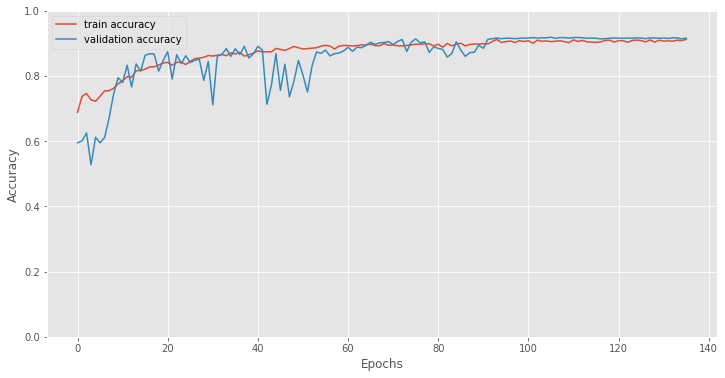

In [ ]:
plot_accuracy(history)

7/7 [==============================] - 1s 103ms/step


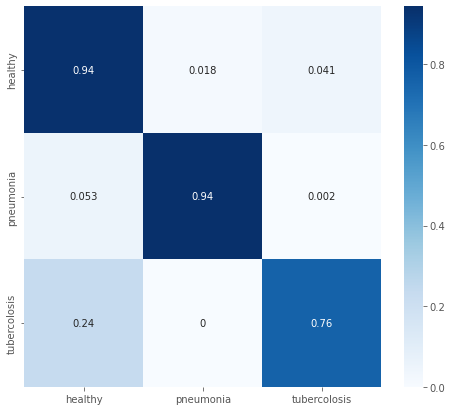

In [ ]:
labels = ['healthy', 'pneumonia', 'tubercolosis']

plt.figure(figsize=(8, 7))
df = build_heatmap(loaded_model, valid_batches)
sns.heatmap(df, annot=True, cmap="Blues", yticklabels=labels, xticklabels=labels)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
df_report = compute_report(loaded_model, valid_batches)
df_report

7/7 [==============================] - 1s 97ms/step


,n,p,t
precision,0.925134,0.959811,0.793651
recall,0.940217,0.944186,0.761421
f1-score,0.932615,0.951934,0.777202
support,920.000000,430.000000,197.000000


7/7 [==============================] - 1s 99ms/step


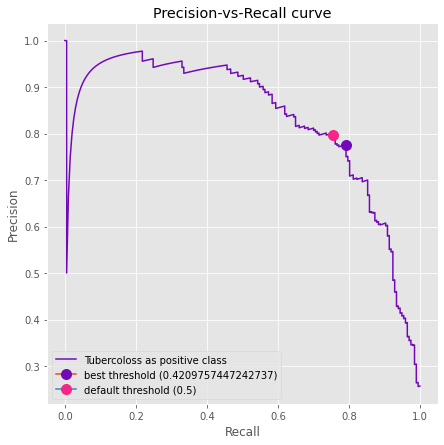

0.42097574

In [ ]:
y_true = np.concatenate([y for x, y in valid_batches], axis=0)
predictions = loaded_model.predict(valid_batches) 
plot_precision_recall_t(y_true, predictions)

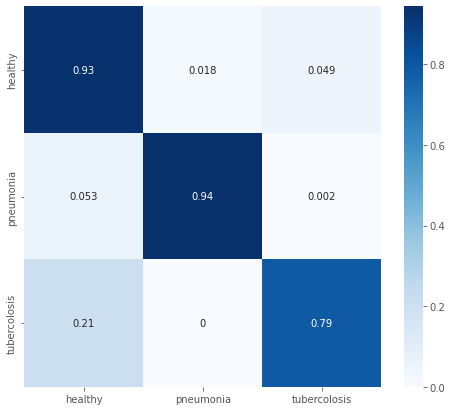

In [ ]:
labels = ['healthy', 'pneumonia', 'tubercolosis']

plt.figure(figsize=(8, 7))
df = build_heatmap_custom(y_true, predictions, 0.42097574, policy=label_policy)
sns.heatmap(df, annot=True, cmap="Blues", yticklabels=labels, xticklabels=labels)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
compute_report_custom(y_true, predictions, 0.42097574, policy=label_policy)

,n,p,t
precision,0.930586,0.959811,0.772277
recall,0.932609,0.944186,0.791878
f1-score,0.931596,0.951934,0.781955
support,920.000000,430.000000,197.000000


# Darknet revisited
Reference: https://reader.elsevier.com/reader/sd/pii/S0010482520301621?token=5DBF2FB3C1B8E35C3845C812EC2C3DC5A4A9EDE7D89D3C5CAF55A61BDA56D9A3BA19AAD31B2503D7E7E1B1F0E9718354&originRegion=eu-west-1&originCreation=20221204161936

In [ ]:
def darknet_block(input_tensor, number_filters, kernel_size=3):
  x = tfkl.Conv2D(number_filters, kernel_size, padding='same')(input_tensor)
  x = tfkl.BatchNormalization()(x)
  x = LeakyReLU(alpha=0.1)(x)
  return x


def darknet_3x(input_tensor, channels_in, channels_out, kernel_size=3):
  x = darknet_block(input_tensor, channels_out, kernel_size)
  x = darknet_block(x, channels_in, kernel_size)
  x = darknet_block(x, channels_out, kernel_size)
  return x 


def darknet():
  # input
  input_layer = Input(shape=input_shape, name='input_layer')

  # data augmentation
  #rescale_layer = tfkl.RandomRotation(0.2)(input_layer)
  #rescale_layer = tfkl.RandomTranslation(0.15, 0.15)(rescale_layer)
  #rescale_layer = tfkl.RandomZoom((0.1, -0.1), None)(rescale_layer)
  #rescale_layer = tfkl.RandomFlip(mode='horizontal_and_vertical')(rescale_layer)

  # feature extraction
  x = darknet_block(input_layer, 8)
  x = tfkl.MaxPooling2D()(x)
  x = darknet_block(x, 16)
  x = tfkl.MaxPooling2D()(x)

  x = darknet_3x(x, 16, 32)
  x = tfkl.MaxPooling2D()(x)

  x = darknet_3x(x, 32, 64)
  x = tfkl.MaxPooling2D()(x)

  x = darknet_3x(x, 64, 128)
  x = tfkl.MaxPooling2D()(x) 

  x = darknet_3x(x, 128, 256)
  x = darknet_block(x, 128, kernel_size=1)
  x = darknet_block(x, 256)
  x = tfkl.Conv2D(3, 3, padding='same', name='last_convolution')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # classifier
  x = tfkl.GlobalAveragePooling2D()(x)
  x = tfkl.Dropout(0)(x)
  output_layer = tfkl.Dense(3, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(x)
  
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='darknet_model')
  return model

# DarkNet19
Build the darknet19 model

In [19]:
import keras
from keras.layers import Conv2D, Input, concatenate
from keras.layers import LeakyReLU, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from keras.layers import Activation
from keras.models import Model
from functools import partial

new_conv = partial(Conv2D ,padding = "same")

def _base_block(out,x):
    "(3,3), Leaky, Batch"
    x =new_conv(out, (3,3))(x)
    x =LeakyReLU(alpha=0.1)(x)
    x =BatchNormalization()(x)
    return x

def _block_1(out, x):     
    """
    output follows:
    out//2, out

    """
    x =  new_conv(out//2, (1,1))(x)
    x =LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = _base_block(out,x)
    return x

def _block_2(out, x):    
    """
    output follows:
    out, out//2, out

    """  
    x =_base_block(out,x)
    x = _block_1(out, x)
    return x


def Darknet19():
    input_layer = Input(shape=input_shape, name='input_layer')
    # data augmentation
    """
    dropblock may help the model recognize the true features of tubercolosis,
    as matter of fact, only tubercolosis images present some white or black 
    rectangular boxes. The model may think the tubercolosis is characterized
    by these boxes. To avoid that, we can randomly place at training time boxes
    in other classes's images, so that the model is invariant to the presence of 
    those boxes.
    """
    preprocess_layer = keras_cv.layers.DropBlock2D(0.1, (20, 70))(input_layer)
    #preprocess_layer = tfkl.RandomRotation(0.2)(preprocess_layer)
    #preprocess_layer = tfkl.RandomTranslation(0.15, 0.15)(preprocess_layer)
    # new layers to try
    #preprocess_layer = tfkl.RandomZoom((0.2, -0.2), None)(preprocess_layer)
    #preprocess_layer = tfkl.RandomFlip(mode='horizontal_and_vertical')(preprocess_layer)
    
    

    # model
    x = _base_block(32,preprocess_layer)
    x =  MaxPooling2D((2,2),strides = 2)(x)
    x = _base_block(64,x)
    x = MaxPooling2D((2,2),strides = 2)(x)
    x = _block_2(128, x)
    x = MaxPooling2D((2,2),strides = 2)(x)
    x = _block_2(256, x)
    x = MaxPooling2D((2,2),strides = 2)(x)
    x = _block_2(512, x)
    x = _block_1(512, x)
    x = MaxPooling2D((2,2),strides = 2)(x)
    x =_block_2(1024, x)
    x = _block_1(512, x)
    x = new_conv(3, (1,1), activation = "linear")(x) # NUMBER OF FILTERS = 1000?
    model = Model(inputs = input_layer, outputs = x)  
    return model

def Darknet_classifier():
    base_model = Darknet19()
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = tfkl.Dense(units=3, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(x)
    model = Model(inputs = base_model.inputs, outputs = output)

    return model


In [ ]:
darkNet = Darknet_classifier()
darkNet.summary()

In [20]:
# Prepare the data batches.
train_batches, valid_batches = prepare_batches(
        TRAINING_DATA_DIR, VALID_DATA_DIR, IMAGE_SHAPE, 64
    )

In [ ]:
e_s = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    restore_best_weights=True,
    patience=15
)

r_LR = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=10,
    mode='max',
    verbose=1,
    min_lr=1e-5
)

if not os.path.exists(f'{dir}/darknet_ckpt/'):
    os.mkdir(f'{dir}/darknet_ckpt/')

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=f'{dir}/trained_models/darknet_ckpt/', # Checkpoint is saved with validation accuracy in the filename
                                                    monitor='val_accuracy', 
                                                    save_weights_only=True, # True to save only weights
                                                    save_best_only=True, # True to save only the best epoch 
                                                    initial_value_threshold=0.85
                                                    )


callbacks = [e_s, r_LR, ckpt_callback]

In [ ]:
#callbacks, model_folder_dir = create_folders_and_callbacks(dir=dir, model_name='darknet_biomedicine', patience=10)

# Prepare and compile the model.
darkNet.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )
    # TRAINING PHASE
 
history = darkNet.fit(
        train_batches,
        epochs=100,
        validation_data=valid_batches,
        verbose=1,
        workers=4,
        use_multiprocessing=True,
        callbacks=callbacks,
        class_weight=weights,
        steps_per_epoch=STEPS_PER_EPOCH
)
best_val = np.max(history.history['val_accuracy'])
darkNet.save(f'{dir}/saved_models/darknet')

Epoch 1/100
193/193 [==============================] - 125s 480ms/step - loss: 0.9882 - accuracy: 0.6626 - val_loss: 1.2173 - val_accuracy: 0.2780 - lr: 0.0030
Epoch 2/100
193/193 [==============================] - 85s 438ms/step - loss: 0.8250 - accuracy: 0.7172 - val_loss: 1.6919 - val_accuracy: 0.2883 - lr: 0.0030
Epoch 3/100
193/193 [==============================] - 84s 437ms/step - loss: 0.7961 - accuracy: 0.7418 - val_loss: 0.5607 - val_accuracy: 0.7783 - lr: 0.0030
Epoch 4/100
193/193 [==============================] - 84s 436ms/step - loss: 0.7717 - accuracy: 0.7548 - val_loss: 1.2488 - val_accuracy: 0.4622 - lr: 0.0030
Epoch 5/100
193/193 [==============================] - 84s 437ms/step - loss: 0.7612 - accuracy: 0.7600 - val_loss: 0.5753 - val_accuracy: 0.7427 - lr: 0.0030
Epoch 6/100
193/193 [==============================] - 84s 436ms/step - loss: 0.7380 - accuracy: 0.7788 - val_loss: 0.7221 - val_accuracy: 0.6884 - lr: 0.0030
Epoch 7/100
193/193 [========================

TypeError: ignored

In [ ]:
if not os.path.exists(f'{dir}/darknet_model/'):
    os.mkdir(f'{dir}/darknet_model/')
darkNet.save(f'{dir}/darknet_model/darknet.h5')

In [21]:
model = keras.models.load_model(f'{dir}/darknet_model/darknet.h5')

In [ ]:
model.evaluate(valid_batches)

25/25 [==============================] - 3s 110ms/step - loss: 0.2143 - accuracy: 0.9386


[0.2143295258283615, 0.9385908246040344]

0.9385908246040344 0.9332091808319092


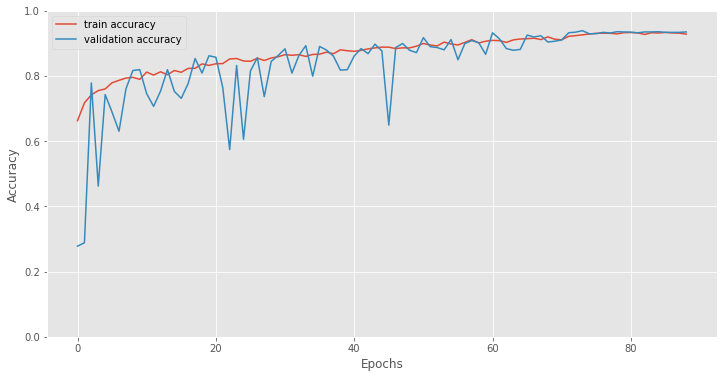

In [ ]:
plot_accuracy(history)

## Evaluate DarkNet


In [25]:
confusion_matrix_df = build_heatmap(model, valid_batches)
report = compute_report(model, valid_batches)

25/25 [==============================] - 3s 107ms/step


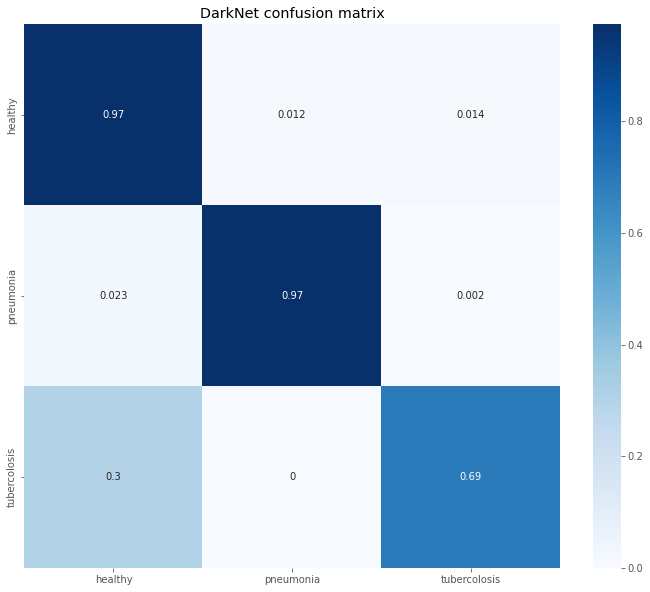

In [26]:
labels = ['healthy', 'pneumonia', 'tubercolosis']

plt.figure(figsize=(12, 10))
plt.title('DarkNet confusion matrix')
sns.heatmap(confusion_matrix_df, annot=True, cmap='Blues', yticklabels=labels, xticklabels=labels)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [27]:
report

,n,p,t
precision,0.927536,0.974419,0.907285
recall,0.973913,0.974419,0.695431
f1-score,0.950159,0.974419,0.787356
support,920.000000,430.000000,197.000000


25/25 [==============================] - 3s 109ms/step


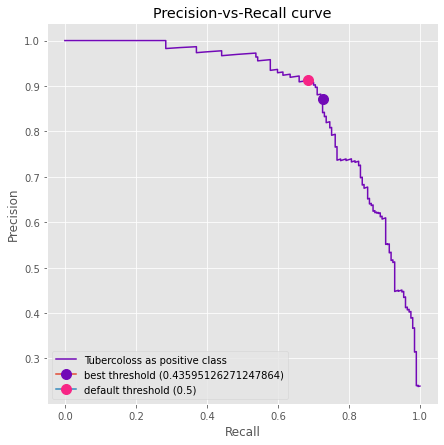

0.43595126

In [28]:
y_true = np.concatenate([y for x, y in valid_batches], axis=0)
predictions = model.predict(valid_batches) 
plot_precision_recall_t(y_true, predictions)

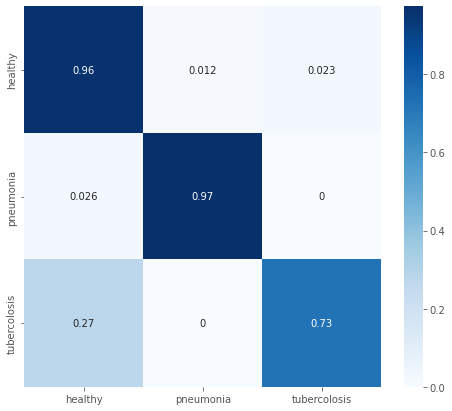

In [29]:
labels = ['healthy', 'pneumonia', 'tubercolosis']

plt.figure(figsize=(8, 7))
df = build_heatmap_custom(y_true, predictions, 0.43595126, policy=label_policy)
sns.heatmap(df, annot=True, cmap="Blues", yticklabels=labels, xticklabels=labels)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [34]:
compute_report_custom(y_true, predictions, 0.43595126, policy=label_policy)

,n,p,t
precision,0.931794,0.974419,0.871951
recall,0.965217,0.974419,0.725888
f1-score,0.948211,0.974419,0.792244
support,920.000000,430.000000,197.000000


## Explainability of DarkNet with Gradcam


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 1)]     0         
                                                                 
 drop_block2d (DropBlock2D)  (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                         

In [ ]:
tubercolosis_img = plt.imread('/content/drive/MyDrive/dataset_bio_AI/dataset/training/t/P00095_1.png')
img = x_ai_pipeline('/content/drive/MyDrive/dataset_bio_AI/dataset/training/t/P00095_1.png')
img_to_display = np.stack((img[0],) * 3, axis=-1)
plt.imshow(tubercolosis_img)

FileNotFoundError: ignored

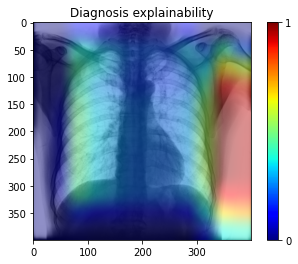

In [ ]:
name_last_conv = "conv2d_18" # <----- change here name of the last convolution layer.
tubercolosis_img_expanded = np.expand_dims(tubercolosis_img, axis=0)

heatmap = make_gradcam_heatmap(tubercolosis_img_expanded, darkNet, name_last_conv)
interpreted_prediction = gradcam(tubercolosis_img_expanded[0], heatmap, alpha=0.003)


cmap = plt.get_cmap('jet')
norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.title('Diagnosis explainability')
plt.imshow(interpreted_prediction)
plt.colorbar(sm, ticks=[0, 1])
plt.show()

Explainability using Occlusion method.

# Explainability with gradcam

In [92]:
_, validation = prepare_batches(
    TRAINING_DATA_DIR, VALID_DATA_DIR, IMAGE_SHAPE, 1
)

sampler = validation.shuffle(2000)
sampler = iter(sampler)

In [93]:
img, label = sampler.next()
tf.argmax(label, axis=-1).numpy()[0]

2

In [35]:
import keras
loaded_model = keras.models.load_model(f'{dir}/cnn_scratch_gap_squeezed/cnn_scratch_gap_squeezed.h5')
loaded_darknet = keras.models.load_model(f'{dir}/darknet_model/darknet.h5')

In [41]:
def display_gradcam(model, img, last_convolution_name):
    name_last_conv = last_convolution_name

    heatmap = make_gradcam_heatmap(img, model, name_last_conv)
    interpreted_prediction = gradcam(img[0], heatmap, alpha=0.003)


    cmap = plt.get_cmap('jet')
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    plt.figure(figsize=(6, 6))
    plt.title('Diagnosis explainability')
    plt.imshow(interpreted_prediction)
    plt.colorbar(sm, ticks=[0, 1])
    plt.grid()
    plt.axis('off')
    plt.show()

## explainability of cnn from scratch

In [94]:
tf.argmax(loaded_model.predict(img), axis=-1).numpy()[0]

1/1 [==============================] - 0s 46ms/step


2

In [ ]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 1)]     0         
                                                                 
 drop_block2d (DropBlock2D)  (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640  

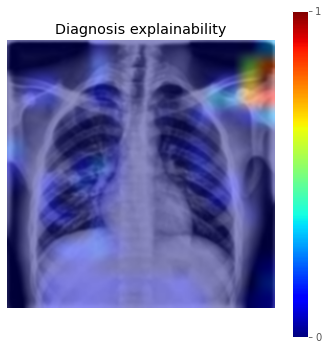

In [95]:
display_gradcam(loaded_model, img, 'conv2d_4')

### explainability of darknet

In [96]:
tf.argmax(loaded_darknet.predict(img), axis=-1).numpy()[0]

1/1 [==============================] - 0s 21ms/step


2

In [ ]:
loaded_darknet.summary()

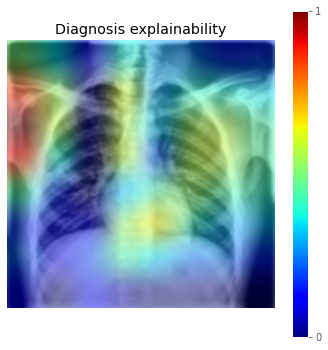

In [97]:
display_gradcam(loaded_darknet, img, 'conv2d_18')

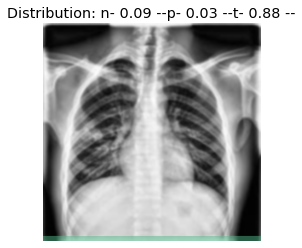

In [98]:
img_for_occlusion = np.squeeze(img)

o_img = get_occlusion_interpretation(loaded_darknet,
                                     img_for_occlusion,
                                     tf.argmax(label, axis=-1).numpy()[0], 
                                     h=100,
                                     w=img_for_occlusion.shape[0],
                                     alpha=0.5,
                                     animation=True,
                                     h_step=10,
                                     w_step=img_for_occlusion.shape[0],
                                     preprocessing=None)

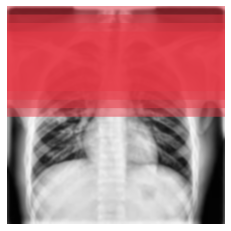

In [99]:
plt.imshow(o_img)
plt.grid()
plt.axis('off')
plt.show()